### Jupyter notebook in a browser is recommended to run this notebook. Estimated runtime is ~2min

In [1]:
import json, pickle, os
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns

# import sys
# sys.path.append('../tutorials/')

import mlp
import importlib
importlib.reload(mlp)
from mlp import MLP1, MLP2, MLP3, encode_data, encode_data_v2_ecr

D = {'output': 'mpl', 'fold': -1, 'idle_wires': False}

# Load shuffled circuits

In [2]:
def check_f(f, f_ext, batch_indices):
    return f.endswith(f_ext) and any([f"batch_%02d"%batch_index in f for batch_index in batch_indices])

def load_circuits(data_dir, step_indices, f_ext='.pk'):
    circuit_batches = []
    data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if check_f(f, f_ext, step_indices)])
    for data_file in tqdm(data_files, leave=True):
        loaded = pickle.load(open(data_file, 'rb'))
        circuit_batches.append(loaded['circuit_batch'])
    return circuit_batches

circuit_batches = load_circuits('data/ising_init_from_qasm_hardware/shuffled/', list(range(60)))

  0%|          | 0/60 [00:00<?, ?it/s]

# Load shuffled, corresponding results

In [3]:
with open('data/ising_init_from_qasm_hardware/shuffled/results.pk', 'rb') as file:
    loaded = pickle.load(file)
noisy_exp_vals = loaded['noisy']
zne_mitigated_vals = loaded['zne_mitigated']
ideal_exp_vals_estimator = loaded['ideal']

In [4]:
noisy_exp_vals = np.array(noisy_exp_vals)
zne_mitigated_vals = np.array(zne_mitigated_vals)

In [5]:
noisy_exp_vals = noisy_exp_vals.reshape(-1, 4).tolist()
zne_mitigated_vals = zne_mitigated_vals.reshape(-1, 4).tolist()

# Unshuffle results

In [6]:
with open('data/ising_init_from_qasm_hardware/shuffled/index_order.json', 'r') as file:
    index_order = json.load(file)

In [7]:
def unshuffle_list(shuffled_list, index_order):
    unshuffled_list = [None] * len(shuffled_list)
    for i, index in enumerate(index_order):
        unshuffled_list[index] = shuffled_list[i]
    return unshuffled_list

In [8]:
noisy_exp_vals = unshuffle_list(noisy_exp_vals, index_order)
zne_mitigated_vals = unshuffle_list(zne_mitigated_vals, index_order)
ideal_exp_vals_estimator = unshuffle_list(ideal_exp_vals_estimator, index_order)

In [9]:
list(zip(ideal_exp_vals_estimator, noisy_exp_vals, zne_mitigated_vals))

[([2.7755575615628914e-17,
   5.551115123125783e-17,
   -2.7755575615628914e-17,
   -8.326672684688674e-17],
  [0.072, -0.0206, 0.0904, 0.0052],
  [0.047599999999999976,
   -0.06840000000000002,
   0.08039999999999999,
   0.023200000000000005]),
 ([0.2822944097650154,
   1.0000000000000004,
   -0.4791774896080656,
   -0.13526912660159063],
  [0.2362, 0.9788, -0.3122, -0.1264],
  [0.2403999999999999, 0.9955999999999996, -0.33889999999999987, -0.1405]),
 ([2.7755575615628914e-17,
   5.551115123125783e-17,
   -2.7755575615628914e-17,
   -8.326672684688674e-17],
  [0.2762, -0.0022, 0.089, -0.0178],
  [0.26849999999999996,
   -0.046800000000000015,
   0.08739999999999999,
   -0.0005999999999999686]),
 ([0.2822944097650154,
   1.0000000000000004,
   -0.4791774896080656,
   -0.13526912660159063],
  [0.231, 0.9826, -0.2886, -0.1048],
  [0.23120000000000002,
   1.0025999999999997,
   -0.31960000000000005,
   -0.11900000000000001]),
 ([5.551115123125783e-17,
   0.0,
   -2.7755575615628914e-17,
 

# Unshuffle circuits

In [10]:
from tqdm.notebook import tqdm
all_circuits = []
for circuits in tqdm(circuit_batches):
    for trans_circuit in circuits:
        all_circuits.append(trans_circuit)

  0%|          | 0/60 [00:00<?, ?it/s]

In [11]:
all_circuits_unshuffled = unshuffle_list(all_circuits, index_order)

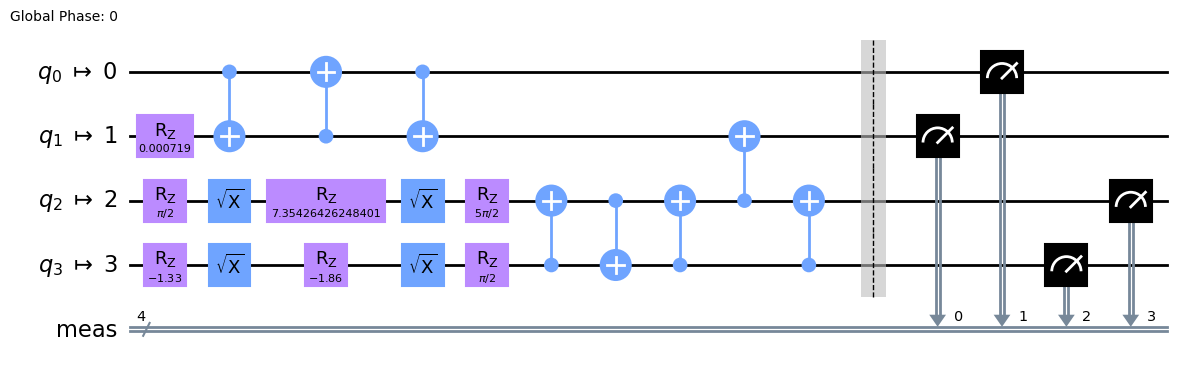

In [12]:
all_circuits_unshuffled[199].draw(**D)

# Group by Trotter step and then train-test split

In [13]:
# Combine circuits and results by steps
all_ideal, all_noisy, all_zne, all_circuits, all_steps = [], [], [], [], []
train_ideal, train_noisy, train_zne, train_circuits, train_steps = [], [], [], [], []
test_ideal, test_noisy, test_zne, test_circuits, test_steps = [], [], [], [], []
for step, i in enumerate(range(0, 2000, 200)):
    all_ideal.extend(ideal_exp_vals_estimator[i:i+200])
    all_noisy.extend(noisy_exp_vals[i:i+200])
    all_zne.extend(zne_mitigated_vals[i:i+200])
    all_circuits.extend(all_circuits_unshuffled[i:i+200])
    all_steps.extend([step]*200)

for step, i in enumerate(range(2000, 3000, 100)):
    all_ideal.extend(ideal_exp_vals_estimator[i:i+100])
    all_noisy.extend(noisy_exp_vals[i:i+100])
    all_zne.extend(zne_mitigated_vals[i:i+100])
    all_circuits.extend(all_circuits_unshuffled[i:i+100])
    all_steps.extend([step]*100)

rows = []
for ideal, noisy, zne, circ, s in zip(all_ideal, all_noisy, all_zne, all_circuits, all_steps):
    rows.append([ideal, noisy, zne, circ, s])

rows = sorted(rows, key=lambda x: (x[-1]))

In [14]:
df = pd.DataFrame(rows)
df.columns = ['ideal', 'noisy', 'zne', 'circ', 'step']
df

,ideal,noisy,zne,circ,step
0,"[2.7755575615628914e-17, 5.551115123125783e-17...","[0.072, -0.0206, 0.0904, 0.0052]","[0.047599999999999976, -0.06840000000000002, 0...","((Instruction(name='rz', num_qubits=1, num_clb...",0
1,"[0.2822944097650154, 1.0000000000000004, -0.47...","[0.2362, 0.9788, -0.3122, -0.1264]","[0.2403999999999999, 0.9955999999999996, -0.33...","((Instruction(name='rz', num_qubits=1, num_clb...",0
2,"[2.7755575615628914e-17, 5.551115123125783e-17...","[0.2762, -0.0022, 0.089, -0.0178]","[0.26849999999999996, -0.046800000000000015, 0...","((Instruction(name='rz', num_qubits=1, num_clb...",0
3,"[0.2822944097650154, 1.0000000000000004, -0.47...","[0.231, 0.9826, -0.2886, -0.1048]","[0.23120000000000002, 1.0025999999999997, -0.3...","((Instruction(name='rz', num_qubits=1, num_clb...",0
4,"[5.551115123125783e-17, 0.0, -2.77555756156289...","[-0.0104, -0.0252, 0.1144, -0.0408]","[-0.011399999999999995, -0.08460000000000004, ...","((Instruction(name='rz', num_qubits=1, num_clb...",0
...,...,...,...,...,...
2995,"[-0.08828510312411605, -0.33965348162590575, 0...","[-0.001, -0.1324, 0.13, 0.1472]","[-0.042300000000000025, -0.1814, 0.19019999999...","((Instruction(name='rz', num_qubits=1, num_clb...",9
2996,"[0.026355128084189855, -0.0033706674882890697,...","[0.1384, 0.125, 0.0562, 0.0674]","[0.14669999999999994, 0.15119999999999997, 0.0...","((Instruction(name='rz', num_qubits=1, num_clb...",9
2997,"[0.03128533930903135, -0.06153497460552665, -0...","[0.0986, -0.0774, 0.0484, 0.1782]","[0.09299999999999999, -0.1106, 0.0626999999999...","((Instruction(name='rz', num_qubits=1, num_clb...",9
2998,"[0.05365543668507869, -0.052795221433028616, -...","[0.1726, 0.0268, 0.087, 0.2026]","[0.18169999999999992, -0.007100000000000058, 0...","((Instruction(name='rz', num_qubits=1, num_clb...",9


In [15]:
train_size_per_step, test_size_per_step = 50, 250
train_rows = df.groupby('step').head(train_size_per_step).reset_index(drop=True)
test_rows = df.groupby('step').tail(test_size_per_step).reset_index(drop=True)

In [16]:
train_ideal, train_noisy, train_zne, train_circuits, train_steps = list(train_rows['ideal']), list(train_rows['noisy']), list(train_rows['zne']), list(train_rows['circ']), list(train_rows['step'])
test_ideal, test_noisy, test_zne, test_circuits, test_steps = list(test_rows['ideal']), list(test_rows['noisy']), list(test_rows['zne']), list(test_rows['circ']), list(test_rows['step'])

# Inspect Train and Test

In [17]:
to_df_train = []
for ideal, noisy, zne, s in zip(train_ideal, train_noisy, train_zne, train_steps):
    row = dict()
    row['ideal'] = ideal
    row['noisy'] = noisy
    row['zne'] = zne
    row['step'] = s
    to_df_train.append(row)

to_df_test = []
for ideal, noisy, zne, s in zip(test_ideal, test_noisy, test_zne, test_steps):
    row = dict()
    row['ideal'] = ideal
    row['noisy'] = noisy
    row['zne'] = zne
    row['step'] = s
    to_df_test.append(row)

df_train = pd.DataFrame(to_df_train)
df_train

,ideal,noisy,zne,step
0,"[2.7755575615628914e-17, 5.551115123125783e-17...","[0.072, -0.0206, 0.0904, 0.0052]","[0.047599999999999976, -0.06840000000000002, 0...",0
1,"[0.2822944097650154, 1.0000000000000004, -0.47...","[0.2362, 0.9788, -0.3122, -0.1264]","[0.2403999999999999, 0.9955999999999996, -0.33...",0
2,"[2.7755575615628914e-17, 5.551115123125783e-17...","[0.2762, -0.0022, 0.089, -0.0178]","[0.26849999999999996, -0.046800000000000015, 0...",0
3,"[0.2822944097650154, 1.0000000000000004, -0.47...","[0.231, 0.9826, -0.2886, -0.1048]","[0.23120000000000002, 1.0025999999999997, -0.3...",0
4,"[5.551115123125783e-17, 0.0, -2.77555756156289...","[-0.0104, -0.0252, 0.1144, -0.0408]","[-0.011399999999999995, -0.08460000000000004, ...",0
...,...,...,...,...
495,"[-0.1195223205337127, -0.422936662137479, -0.0...","[-0.1414, -0.334, -0.0956, -0.105]","[-0.15399999999999994, -0.46950000000000003, -...",9
496,"[0.03468435284046983, 0.5033074694656495, -0.2...","[-0.0138, 0.2812, -0.098, 0.0674]","[0.03960000000000001, 0.3844999999999999, -0.1...",9
497,"[-0.038374547811965115, -0.015929757330378075,...","[0.0086, -0.1234, -0.0582, -0.1892]","[-0.02970000000000004, -0.15299999999999994, -...",9
498,"[-0.042503203687466296, -0.04886391037068477, ...","[0.0142, -0.1112, -0.0958, -0.1924]","[-0.0028000000000000178, -0.1591, -0.126199999...",9


In [18]:
df = pd.DataFrame(to_df_test)

def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in df.columns:
    if col not in ['step', 'ideal']:
        df[f'L2_{col}'] = df.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)

#df_mean = df.groupby('step').agg('mean')
df_mean = df.groupby('step').mean(numeric_only=True)
df_ste = df.groupby('step').std(numeric_only=True) / np.sqrt(len(df[df['step']==0]))
#df_ste = df.groupby('step').aggregate(numeric_only=True) / np.sqrt(len(df[df['step']==0]))

In [19]:
df_mean

,L2_noisy,L2_zne
step,,
0,0.143743,0.143702
1,0.175321,0.169557
2,0.222085,0.183910
3,0.219112,0.177614
4,0.225672,0.184633
5,0.193042,0.169360
6,0.217714,0.183535
7,0.232615,0.204955
8,0.230549,0.222320


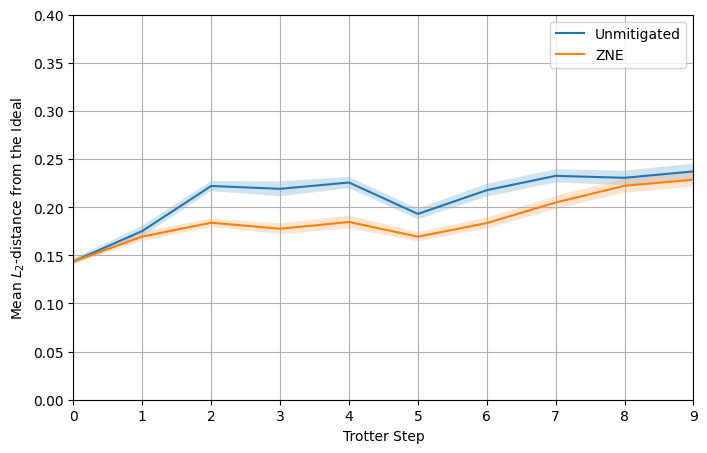

In [20]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
xs = sorted(set(df.step))
legend_labels = ['Unmitigated', 'ZNE']
for i, col in enumerate(['L2_noisy', 'L2_zne']):
# legend_labels = ['Unmitigated', 'RF Mitigated']
# for i, col in enumerate(['L2_noisy', 'L2_rfr_list']):
    plt.plot(xs, df_mean[col], label=legend_labels[i])
    plt.fill_between(x=xs, y1=df_mean[col]-df_ste[col], y2=df_mean[col]+df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
plt.ylim([0, 0.4])
plt.xlim([0, 9])
ymin, ymax = plt.gca().get_ylim()
plt.ylim(ymin, ymax)
plt.legend()
plt.grid(None)
plt.show()

# Train random forest

In [21]:
X_train, y_train = encode_data_v2_ecr(train_circuits, train_ideal, train_noisy, obs_size=4, two_q_gate='cx')
X_test, y_test = encode_data_v2_ecr(test_circuits, test_ideal, test_noisy, obs_size=4, two_q_gate='cx')

In [22]:
BATCH_SIZE = 32
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*1000, shuffle=False)

In [23]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [24]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rfr_tree_list = []
for q in range(4):
    rfr = RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train, y_train.iloc[:, q])
    rfr_tree_list.append(rfr)

RMSE_noisy_0: 0.06371962731138575
RMSE_mitigated_0: 0.03000883694779725
RMSE_noisy_1: 0.14266696586500827
RMSE_mitigated_1: 0.10135703160630764
RMSE_noisy_2: 0.09719701642269073
RMSE_mitigated_2: 0.054267092612719066
RMSE_noisy_3: 0.1449852102185559
RMSE_mitigated_3: 0.08967498271321168
RMSE_noisy: 0.11713456496421219
RMSE_mitigated: 0.07443167675165892


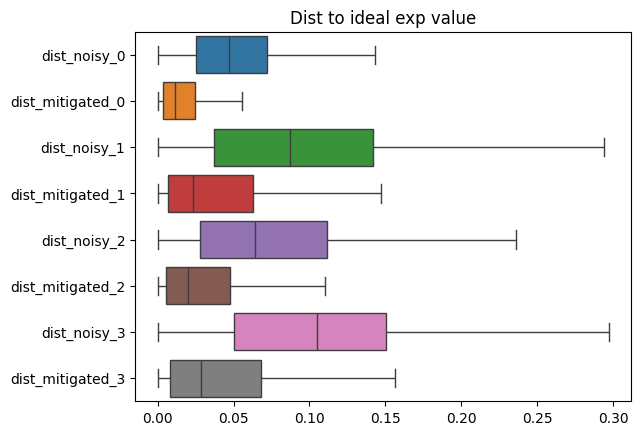

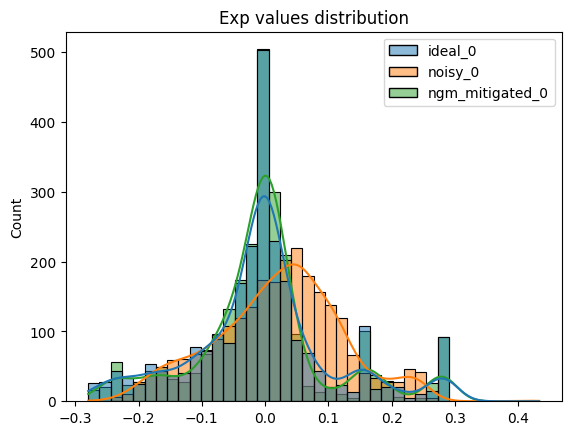

In [25]:
distances = []

num_spins = 4

for batch_X, batch_y in test_loader:
    out = []
    for q, model in enumerate(rfr_tree_list):
        out.append(model.predict(batch_X[:, :]))
    out = np.array(out).transpose()

    for ideal, noisy, ngm_mitigated in zip(
        batch_y.tolist(),
        batch_X[:, -num_spins:].tolist(),
        out.tolist()
    ):
        for q in range(num_spins):
            ideal_q = ideal[q]
            noisy_q = noisy[q]
            ngm_mitigated_q = ngm_mitigated[q]
            distances.append({
                f"ideal_{q}": ideal_q,
                f"noisy_{q}": noisy_q,
                f"ngm_mitigated_{q}": ngm_mitigated_q,
                f"dist_noisy_{q}": np.abs(ideal_q - noisy_q),
                f"dist_mitigated_{q}": np.abs(ideal_q - ngm_mitigated_q),
                f"dist_sq_noisy_{q}": np.square(ideal_q - noisy_q),
                f"dist_sq_mitigated_{q}": np.square(ideal_q - ngm_mitigated_q),
            })

plt.style.use({'figure.facecolor':'white'})

df = pd.DataFrame(distances)

for q in range(num_spins):
    print(f'RMSE_noisy_{q}:', np.sqrt(df[f"dist_sq_noisy_{q}"].mean()))
    print(f'RMSE_mitigated_{q}:', np.sqrt(df[f"dist_sq_mitigated_{q}"].mean()))

print(f'RMSE_noisy:', np.sqrt(np.mean([df[f"dist_sq_noisy_{q}"].mean() for q in range(num_spins)])))
print(f'RMSE_mitigated:', np.sqrt(np.mean([df[f"dist_sq_mitigated_{q}"].mean() for q in range(num_spins)])))

sns.boxplot(data=df[["dist_noisy_0", "dist_mitigated_0", "dist_noisy_1", "dist_mitigated_1", "dist_noisy_2", "dist_mitigated_2", "dist_noisy_3", "dist_mitigated_3"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal_0'], df['noisy_0'], df["ngm_mitigated_0"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

# Plot testing results as a function of Trotter steps

In [26]:
to_df = []

start = 0 #300*9
end = 100000000 #300*10

models = [(rfr_tree_list, 'rfr_list')]
models.append((None, 'zne'))

for circ, ideal, noisy, zne, s in tqdm(zip(test_circuits, test_ideal, test_noisy, test_zne, test_steps), total=len(test_circuits)):
    row = dict()
    row['ideal'] = ideal
    row['noisy'] = noisy
    row['step'] = s

    X, _ = encode_data_v2_ecr([circ], ideal, [noisy], obs_size=4, two_q_gate='cx')

    for j, (model, name) in enumerate(models):
        if name in ['rfr_list']:
            row[name] = []
            for q, m in enumerate(model):
                row[name].append(m.predict(X))
            row[name] = np.array(row[name]).transpose()[0]
        elif name in ['zne']:
            row[name] = zne
        else:
            raise NotImplementedError

    to_df.append(row)

df = pd.DataFrame(to_df)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [27]:
df = pd.DataFrame(to_df)

def l2_dist(list1, list2):
    return np.sqrt(np.sum([(a - b)**2 for a, b in zip(list1, list2)]))

for col in df.columns:
    if col not in ['step', 'ideal']:
        df[f'L2_{col}'] = df.apply(lambda row: l2_dist(row['ideal'], row[col]), axis=1)

# df_mean = df.groupby('step').agg('mean')
# df_ste = df.groupby('step').agg('std') / np.sqrt(len(df[df['step']==0]))
df_mean = df.groupby('step').mean(numeric_only=True)
df_ste = df.groupby('step').std(numeric_only=True) / np.sqrt(len(df[df['step']==0]))

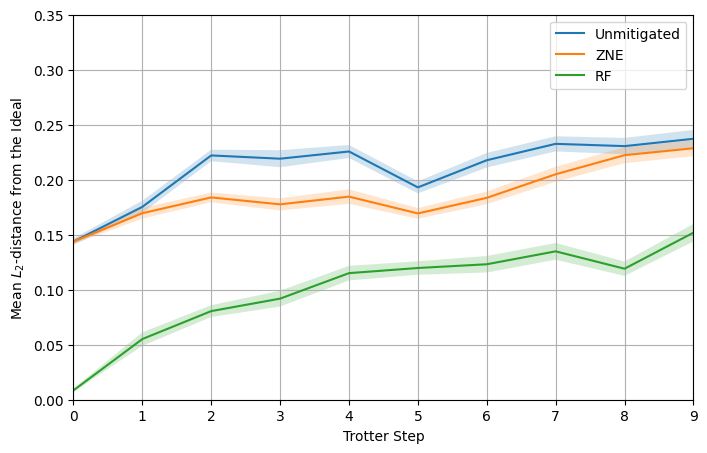

In [28]:
plt.style.use({'figure.facecolor':'white'})
plt.figure(figsize=(8, 5))
xs = sorted(set(df.step))
legend_labels = ['Unmitigated', 'ZNE', 'RF']
for i, col in enumerate(['L2_noisy', 'L2_zne', 'L2_rfr_list']):
# legend_labels = ['Unmitigated', 'RF Mitigated']
# for i, col in enumerate(['L2_noisy', 'L2_rfr_list']):
    plt.plot(xs, df_mean[col], label=legend_labels[i])
    plt.fill_between(x=xs, y1=df_mean[col]-df_ste[col], y2=df_mean[col]+df_ste[col], alpha=0.2)
plt.xlabel('Trotter Step')
plt.ylabel(r'Mean $L_2$-distance from the Ideal')
plt.ylim([0, 0.35])
plt.xlim([0, 9])
ymin, ymax = plt.gca().get_ylim()
plt.ylim(ymin, ymax)
plt.legend()
plt.grid(None)
plt.show()

In [29]:
from scripts.from_circ_to_numpy import operations_to_features
from qiskit_ibm_runtime.fake_provider import FakeAlgiers

ModuleNotFoundError: No module named 'qiskit.circuit.classical'

In [ ]:
train_ideal_exp_vals = train_ideal
test_ideal_exp_vals = test_ideal
backend = FakeAlgiers()

In [ ]:
X_train, y_train = operations_to_features(train_circuits, train_ideal_exp_vals, n_qubits=5, backend=backend)
X_test, y_test = operations_to_features(test_circuits, test_ideal_exp_vals, n_qubits=5, backend=backend)

In [ ]:
from scripts.model import *
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm
import json, os


sequence_input_size = 7
sequence_hidden_size = 4
sequence_num_layers = 4
sequence_model_type = 'LSTM'
sequence_dropout = 0.2
ann_hidden_layers = 2
ann_hidden_units = 64
ann_dropout = 0
noisy_first = True

num_epochs = 2